<a href="https://colab.research.google.com/github/edwingallardo516/Vision-Artificial/blob/main/sacar_informacion_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalar Tesseract, herramienta para obtener texto a partir de imágenes

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Librerias necesarias

In [29]:
import pytesseract
import cv2 as cv
import re
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

Cargar imagen de prueba

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36277  100 36277    0     0   632k      0 --:--:-- --:--:-- --:--:--  632k


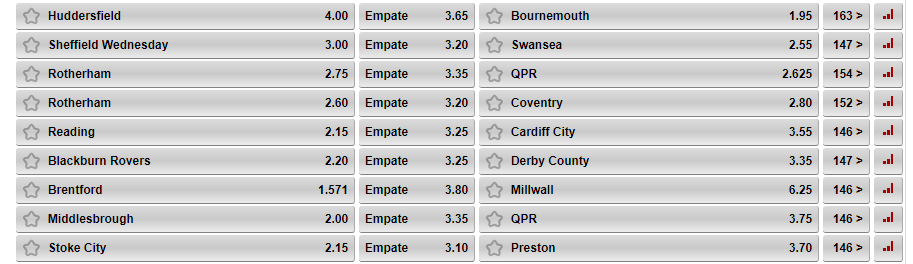

In [33]:
!curl -o imagen_prueba.png https://raw.githubusercontent.com/edwingallardo516/Vision-Artificial/main/prueba_imagen.png
image_src = cv.imread('imagen_prueba.png')
cv2_imshow(image_src)

Aplicar filtros para seleccionar las areas deseadas 

In [35]:
lim1 = np.array([200, 200, 200], np.uint8)
lim2 = np.array([240, 240, 240], np.uint8)
mask = cv.inRange(image_src, lim1, lim2) #region de información
cnts = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0] #contorno de las regiones de interes

Funciones que se encargan de filtrar el texto obtenido a partir de la imagen 


In [38]:
def getText(img):
    custom_config = r'--oem 3 --psm 6'
    data = pytesseract.image_to_string(img, config=custom_config)
    data = re.sub("\\n|\'|\\x0c|\´","",data) #Eliminar caracteres indeseados 
    #obtener numeros de la cadena de texto
    G,numeros = getNums(data)
    #obtener nombre del equipo de la cadeba de texto
    name1 = getName(data,numeros)
    return name1, G 

def getNums(data):
    #obtener numeros
    numeros = re.split('\D+',data) # Separar los caracteres numericos
    numeros.remove("") # eliminar espacios
    s=""
    num = int(s.join(map(str,numeros))) # convertir el valor a entero 
    if(num <= 1000): # convertir el valor al número real
        G = num/100
    else:
        G = num/1000
    return G,numeros

def getName(data,numeros):
    name1 = re.split('\W+',data) # Eliminar caracteres indeseados
    name1 = [l for l in name1 if l not in numeros] # filtrar los caracteres númericos
    s=" "
    name1 = s.join(name1) # crear la cadena de texto
    return name1


Filtrar y obtener la información deseada a partir del contorno de las regiones de interes 

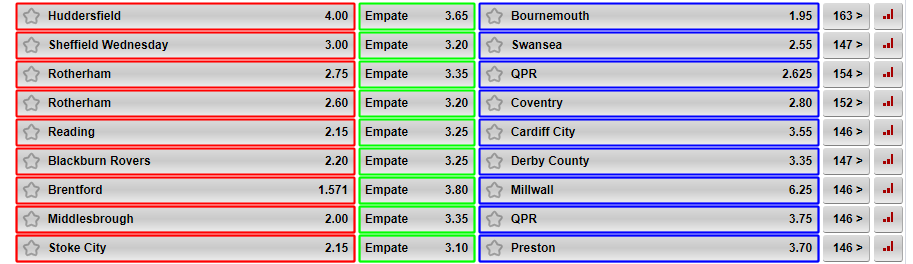

In [44]:
# Vectores para guardar la información de interes
eq_visitante = [] # Equipos visitantes
eq_local = [] # Equipos locales
G_visitante = [] # Porcentaje a favor visitante
G_local = [] # Porcentaje a favor local
num_empate = [] # Porcentaje Empate

equipo = False; # false = visitante, true = local
for c in cnts:
    area = cv.contourArea(c) # calcular área de los contornos
    # Detectar equipos
    if area > 5000 and area < 10000:
        (x,y,w,h) = cv.boundingRect(c)
        rec_todo = image_src[y:y+h,x+25:x+w]
        if equipo == True:
            name_equipo, g = getText(rec_todo)
            eq_local.append(name_equipo)
            G_local.append(g)
            color = (0,0,255)
            equipo = not(equipo)
        else:
            name_equipo, g = getText(rec_todo)
            eq_visitante.append(name_equipo)
            G_visitante.append(g)
            color = (255,0,0)
            equipo = not(equipo)

        cv.rectangle(image_src, (x,y), (x+w,y+h),color, 1, cv.LINE_AA) # mostrar detecciones
    
    #detectar empate
    if area > 2000 and area < 5000:
        (x,y,w,h) = cv.boundingRect(c)
        cv.rectangle(image_src, (x,y), (x+w,y+h),(0, 255, 0), 1, cv.LINE_AA) # mostrar detecciones
        rec_todo = image_src[y:y+h,x:x+w]
        emp, num_emp = getText(rec_todo)
        num_empate.append(num_emp)

cv2_imshow(image_src)

Almacenar, organizar y presentar la información obtenida en un dataframe

In [45]:
df = pd.DataFrame()

df['Equipo Local'] = np.flip(eq_local)
df['A favor 1'] = np.flip(G_local)
df['Empate'] = np.flip(num_empate)
df['Equipo Visitante'] = np.flip(eq_visitante)
df['A favor 2'] = np.flip(G_visitante)

print(df)

          Equipo Local  A favor 1  Empate Equipo Visitante  A favor 2
0         Huddersfield      4.000    3.65      Bournemouth      1.950
1  Sheffield Wednesday      3.000    3.20          Swansea      2.550
2            Rotherham      2.750    3.35              QPR      2.625
3            Rotherham      2.600    3.20      280Coventry      2.800
4              Reading      2.150    3.25     Cardiff City      3.550
5     Blackburn Rovers      2.200    3.25     Derby County      3.350
6            Brentford      1.571    3.80         Millwall      6.250
7        Middlesbrough      2.000    3.35              QPR      3.750
8           Stoke City      2.150    3.10          Preston      3.700
